In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler

from transformers import BertTokenizer

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow import keras
from tensorflow.keras import layers

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#sklearn processing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#configs
max_tokens = 20000
embed_dim  = 300
num_heads  = 2
dense_dim  = 32
development_mode = False


/kaggle/input/glove/glove.6B.300d.txt
/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv


In [2]:
# process glove embeddings.
path_to_glove_file = '/kaggle/input/glove/glove.6B.300d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep= " ")
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors')

Found 400000 word vectors


In [3]:
#example embeddings for "the"
embeddings_index['the']

array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [4]:
sample_submission_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv')
train_data_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test_from_comp = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')

In [5]:
train, test = train_test_split(train_data_raw, test_size=0.2, random_state=21) #20% for test
train, val = train_test_split(train, test_size=0.1, random_state=21) # 10% for validation
train

targets=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

sc_y = StandardScaler()
train_targets = sc_y.fit_transform(train[targets])
val_targets = sc_y.transform(val[targets])
test_targets = sc_y.transform(test[targets])

train_targets_ds = tf.convert_to_tensor(train_targets)
val_targets_ds = tf.convert_to_tensor(val_targets)
test_targets_ds = tf.convert_to_tensor(test_targets)

train_text_only = tf.convert_to_tensor(train['full_text'])
val_text_only = tf.convert_to_tensor(val['full_text'])
test_text_only = tf.convert_to_tensor(test['full_text'])


max_length = int(train['full_text'].str.len().max())

## for submission 
all_sc_y = StandardScaler()
all_train_targets = all_sc_y.fit_transform(train_data_raw[targets])
all_train_targets_ds = tf.convert_to_tensor(all_train_targets)
all_train_text_only = tf.convert_to_tensor(train_data_raw['full_text'])

all_test_text_only = tf.convert_to_tensor(test_from_comp['full_text'])


2022-11-27 02:26:05.953980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 02:26:06.100052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 02:26:06.100848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 02:26:06.103150: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
# text_vectorization = layers.TextVectorization(
#     max_tokens=max_tokens,
#     output_mode="multi_hot"
# )

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

#use the dataset to index the dataset vocab via the adapt method
text_vectorization.adapt(train_text_only)

train_features_ds = text_vectorization(train_text_only)
val_features_ds = text_vectorization(val_text_only)
test_features_ds = text_vectorization(test_text_only)

#for submission
all_train_features_ds = text_vectorization(all_train_text_only)
all_test_features_ds = text_vectorization(all_test_text_only)


2022-11-27 02:26:08.601513: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [7]:
vocabulary = text_vectorization.get_vocabulary() #get vocab from text_vectorization function
word_index = dict(zip(vocabulary, range(len(vocabulary)))) #use vocabulary to map from words to their index in the vocab

embedding_matrix = np.zeros((max_tokens, embed_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [12]:
# Transformer Encoder

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation='relu'),
            layers.Dense(embed_dim),]
        )

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
    
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim
        })
        return config



def get_model(max_tokens=max_tokens, hidden_dim=32):
    
    embedding_layer = layers.Embedding(
        max_tokens,
        embed_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        mask_zero=True
    )

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x =  TransformerEncoder(embed_dim, dense_dim, num_heads)(embedded)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(6, activation=None)(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="mean_absolute_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError(
                name='root_mean_squared_error', dtype=None
            )]
    )
    return model

#train model and test
model = get_model()
model.summary()


if development_mode:
    callbacks = [
        keras.callbacks.ModelCheckpoint("model_glove_transformer_dev.keras", save_best_only=True)
    ]
    hist = model.fit(
        x=train_features_ds,
        y=train_targets_ds,
        validation_data = (
            val_features_ds, val_targets_ds
        ),
        epochs=25,
        
        callbacks=callbacks, 
        batch_size=12
    )

    model = keras.models.load_model("model_glove_transformer_dev.keras",
                                    custom_objects={
                                    "TransformerEncoder": TransformerEncoder
                                    })
    print(f"Test acc: {model.evaluate(test_features_ds, test_targets_ds, 1)}")


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 300)         6000000   
_________________________________________________________________
transformer_encoder_3 (Trans (None, None, 300)         742832    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 300)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 1806      
Total params: 6,744,638
Trainable params: 744,638
Non-trainable params: 6,000,000
___________________________________________

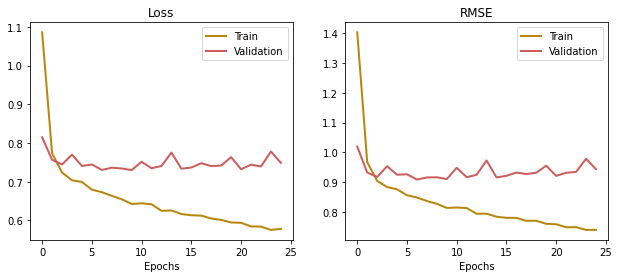

In [13]:
if development_mode:

    # grab history
    history = hist.history

    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 3, 1)

    plt.plot(history['loss'], lw=2, color='darkgoldenrod')
    plt.plot(history['val_loss'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    #plt.ylim(0.5,0.7)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title('Loss');

    ax = fig.add_subplot(1, 3, 2)

    plt.plot(history['root_mean_squared_error'], lw=2, color='darkgoldenrod')
    plt.plot(history['val_root_mean_squared_error'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    #plt.ylim(0.5,0.7)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title('RMSE');


## Submission to contest

In [14]:
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("model_glove_transformer_dev.keras", save_best_only=True)
]
hist = model.fit(
    x=all_train_features_ds,
    y=all_train_targets_ds,
    validation_data = None,
    epochs=5,
    callbacks=callbacks,
    batch_size=12
)

# #load pretrained model to be used in contest
# model = keras.models.load_model("model_glove_bidir_lstm.keras")


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 300)         6000000   
_________________________________________________________________
transformer_encoder_4 (Trans (None, None, 300)         742832    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 300)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 1806      
Total params: 6,744,638
Trainable params: 744,638
Non-trainable params: 6,000,000
___________________________________________

KeyboardInterrupt: 

In [ ]:
test_predictions = model.predict(all_test_features_ds)
test_predictions = pd.DataFrame(all_sc_y.inverse_transform(test_predictions))

test_from_comp['cohesion'] = test_predictions[0]
test_from_comp['syntax'] = test_predictions[1]
test_from_comp['vocabulary'] = test_predictions[2]
test_from_comp['phraseology'] = test_predictions[3]
test_from_comp['grammar'] = test_predictions[4]
test_from_comp['conventions'] = test_predictions[5]
test_from_comp

In [ ]:
res = test_from_comp.drop("full_text",axis=1)
res.to_csv("/kaggle/working/submission.csv",index=False)